# This notebook studies how the speed of the moving source influences seeking performance.

In [1]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import animation, rc

import pickle as pkl
import networkx as nx
from matplotlib import style
from functools import partial

import sys
sys.path.append('../')

from utils.dLdp import analytic_dLdp,analytic_dhdz,analytic_dhdq,analytic_FIM
from utils.CentralizedEKF import CentralizedEKF
from CircleGenerator import CircleGenerator

import time

%load_ext autoreload
%autoreload 2

In [2]:
def single_meas_func(C1,C0,k,b,dist):
    return k*(dist-C1)**b+C0

def joint_meas_func(C1s,C0s,ks,bs,x,ps):

    # Casting for the compatibility of jax.numpy

    C1=np.array(C1s)
    C0=np.array(C0s)
    k=np.array(ks)
    b=np.array(bs)
    p=np.array(ps)

    # Keep in mind that x is a vector of [q,q'], thus only the first half of components are observable.    
    dists=np.linalg.norm(x[:len(x)//2]-p,axis=1)

    return single_meas_func(C1,C0,k,b,dists) 

In [20]:
def main(N_trails,N_sen,N_iter,source_vel):
    '''
        source_ang_vel: the angular velcity of the source circular motion, measured in degree/step.
    '''
    
    
    '''Experiment Parameters'''
  
    C_gain=0.1

    # Set up virtual sensors
    C1=-0.3 # Setting C1 as a negative number mitigates the blowing-up effect when the sensors are close to the source.
    C0=0
    k=1
    b=-2
    noise_std = 0.01
    minimum_sensing_reading=1e-5

    # The step size of each sensor
    max_linear_speed=0.1

    # Terminal condition
    contact_radius = 0.1
    
    origin = np.array([0,0])
    radius = 6.0
    theta_0 = 3*np.pi/2
    dtheta = source_vel/(radius)

    source = CircleGenerator(origin,radius,dtheta)


    data={'p':[],'qhat':[],'q':[]}
    t = time.time()
    for _ in range(N_trails):

        '''Initialize Key Data Structures'''
        p_0 = (np.random.rand(N_sen,2)-0.5)*3
        p = np.array(p_0) # Sensor Positions
        
        qhat_0 = np.array([3,4])
        qhat = np.array(qhat_0) # Initial source location estimates
        
        q_0 = np.array([6,6])
        q = q_0 # Actual source location

        # The Centralized EKF
        estimator = CentralizedEKF(qhat_0)

        C1s=C1*np.ones(N_sen)
        C0s = C0*np.ones(N_sen)
        ks = k * np.ones(N_sen)
        bs = b*np.ones(N_sen)

        h=partial(joint_meas_func,C1s,C0s,ks,bs)# Freeze the coefficients, the signature becomes h(z,ps))
        dhdz=partial(analytic_dhdz,C1s=C1s,C0s=C0s,ks=ks,bs=bs)
        dhdqs=partial(analytic_dhdq,C1s=C1s,C0s=C0s,ks=ks,bs=bs)

        '''Main Loop'''

        p_history = []
        qhat_history = []
        q_history = []
        for _ in range(N_iter):
            # Measure
            r = np.linalg.norm(q-p,axis=1)
            y = k* ((r-C1)**b)+C0 + np.random.randn(N_sen)*noise_std
            y[y<=0]=minimum_sensing_reading # We don't want y to be zero or negative.

            # Estimate

            qhat=estimator.update_and_estimate_loc(h,dhdz,y,p)

            # Gradient update

            dp=analytic_dLdp(qhat,p,C1,C0,k,b)
            p-=max_linear_speed*(dp.T/np.linalg.norm(dp,axis=1)).T

            # Record data
            p_history.append(np.array(p))
            qhat_history.append(np.array(qhat)) 
            q_history.append(np.array(q))
            
            # The source moves
            q = source.next_waypoint(q)

            
        data['p'].append(np.array(p_history))
        data['qhat'].append(np.array(qhat_history))
        data['q'].append(q_history)

    print('Time:',time.time()-t)
    return data

In [39]:
vels = [0.01,0.05,0.075,0.1,0.5,0.2]
N_trails = 100
N_iter=150
n_sen=6
data={}

for vel in vels:
    data[vel] = main(N_trails,n_sen,N_iter,vel)

Time: 1.897123098373413
Time: 1.8561570644378662
Time: 1.9198720455169678
Time: 1.836921215057373
Time: 1.8074920177459717
Time: 1.8560807704925537


In [40]:
filepath = "../Data/VelocityTest_Centralized.pkl"
with open(filepath,'wb') as file:
    pkl.dump(data,file)


(100, 150, 2) (100, 150, 6)
(100, 150, 2) (100, 150, 6)
(100, 150, 2) (100, 150, 6)
(100, 150, 2) (100, 150, 6)
(100, 150, 2) (100, 150, 6)
(100, 150, 2) (100, 150, 6)


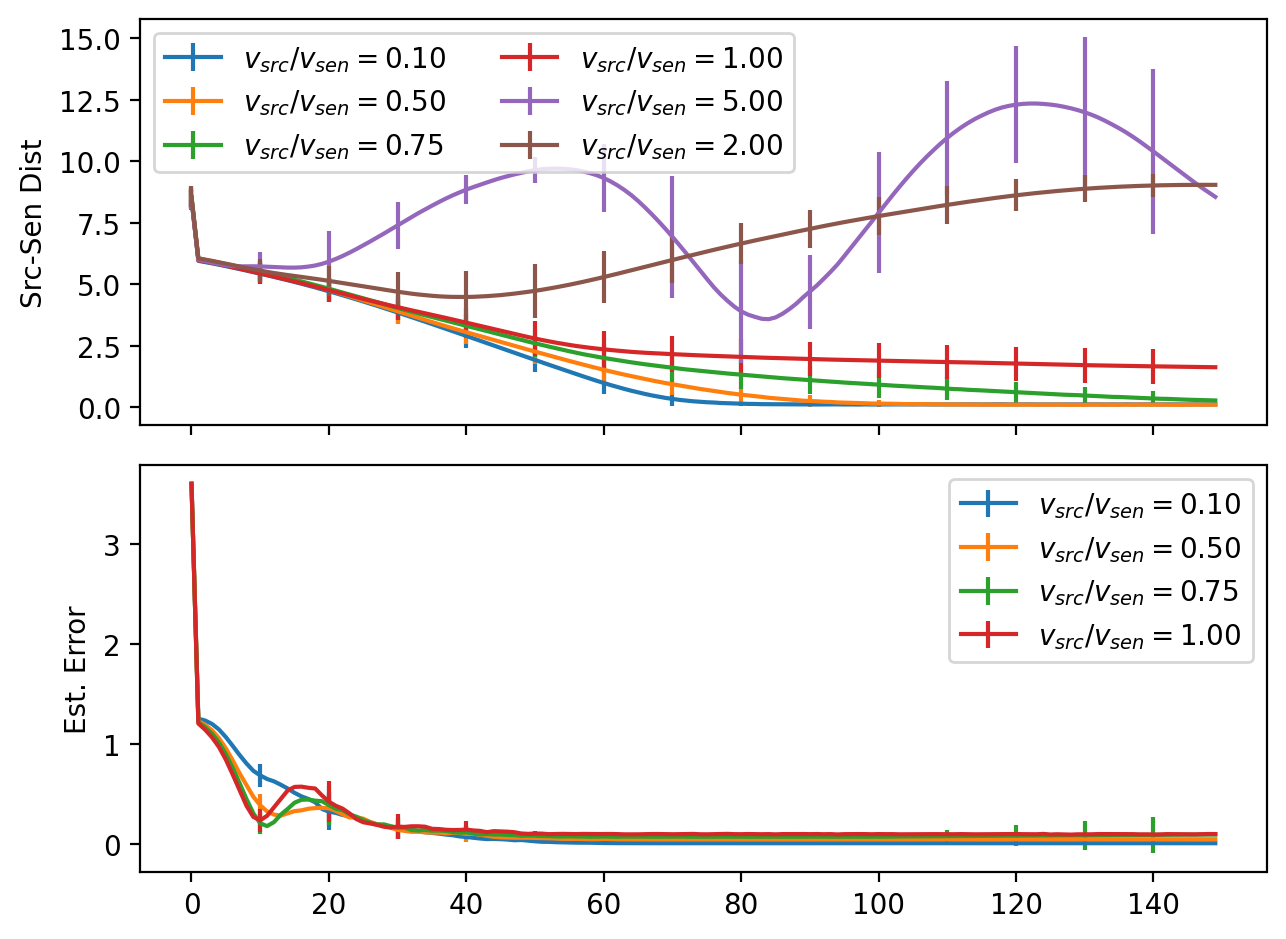

In [54]:
'''Plotting'''

with open(filepath,'rb') as file:
    data=pkl.load(file)
fig,axes=plt.subplots(2,dpi=200,sharex=True)
for name,d in data.items():
    ps = np.array(d['p'])
    qhat = np.array(d['qhat'])
    q = np.array(d['q'])
     # qhat.shape=ps.shape=(N_trails,N_iter,space_dim)
    dist = np.linalg.norm(ps-q[:,:,np.newaxis,:],axis=-1)
    # dist.shape = (N_trails,N_iter,N_sen)
    print(qhat.shape,dist.shape)
 
    
    ave_median_dist = np.mean(np.median(dist,axis=-1),axis=0)
    std_median_dist = np.std(np.median(dist,axis=-1),axis=0)
    N_iter=len(ave_median_dist)

    x = np.arange(N_iter)
#     axes[0].plot(x,ave_median_dist,label= name)
#     axes[0].fill_between(x,ave_median_dist+std_median_dist,ave_median_dist-std_median_dist,alpha=0.2)

    axes[0].errorbar(x,ave_median_dist,yerr=std_median_dist,label= r"$v_{src}/v_{sen}=$"+"${:.2f}$".format(name/0.1),errorevery=10)
    axes[0].set_ylabel('Src-Sen Dist')
    axes[0].legend(ncol =2 )
    

    if name/0.1<=1:
        err = np.linalg.norm(qhat-q,axis=-1)
        ave_median_err = np.mean(err,axis=0)
        std_median_err = np.std(err,axis=0)
        x = np.arange(N_iter)
    #     axes[1].plot(x,ave_median_err,label= name)
    #     axes[1].fill_between(x,ave_median_err+std_median_err,ave_median_err-std_median_err,alpha=0.2)
        axes[1].errorbar(x,ave_median_err,yerr=std_median_err,label= r"$v_{src}/v_{sen}=$"+"${:.2f}$".format(name/0.1),errorevery=10)
        axes[1].set_ylabel('Est. Error')
        axes[1].legend()
# fig.suptitle('6 Sensors')
fig.tight_layout()
plt.show()